OK, thus far we have been talking about linear models. All these can be viewed as a single-layer neural net. The next step is to move on to multi-layer nets. Training these is a bit more involved, and implementing from scratch requires time and effort. Instead, we just use well-established libraries. I prefer PyTorch, which is based on an earlier library called Torch (designed for training neural nets via backprop).

In [1]:
import numpy as np
import torch
import torchvision

Torch handles data types a bit differently. Everything in torch is a *tensor*.

In [2]:
a = np.random.rand(2,3)
b = torch.from_numpy(a)

# Q4.1 Display the contents of a, b
# ...
# ...
print('this is a',a)
print('this is b',b)

this is a [[0.11386793 0.85511363 0.4341172 ]
 [0.23501321 0.98825262 0.43529673]]
this is b tensor([[0.1139, 0.8551, 0.4341],
        [0.2350, 0.9883, 0.4353]], dtype=torch.float64)


The idea in Torch is that tensors allow for easy forward (function evaluations) and backward (gradient) passes.

In [3]:
A = torch.rand(2,2)
b = torch.rand(2,1)
x = torch.rand(2,1, requires_grad=True)

y = torch.matmul(A,x) + b

print(y)
z = y.sum()
print(z)
z.backward()
print(x.grad)
print(x)

tensor([[0.9376],
        [0.8592]], grad_fn=<AddBackward0>)
tensor(1.7968, grad_fn=<SumBackward0>)
tensor([[1.5376],
        [0.7848]])
tensor([[0.8296],
        [0.3193]], requires_grad=True)


Notice how the backward pass computed the gradients using autograd. OK, enough background. Time to train some networks. Let us load the *Fashion MNIST* dataset, which is a database of grayscale images of clothing items.

In [4]:
trainingdata = torchvision.datasets.FashionMNIST('./FashionMNIST/',train=True,download=True,transform=torchvision.transforms.ToTensor())
testdata = torchvision.datasets.FashionMNIST('./FashionMNIST/',train=False,download=True,transform=torchvision.transforms.ToTensor())


Extracting ./FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/FashionMNIST/raw


Extracting ./FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



Extracting ./FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/FashionMNIST/raw


Extracting ./FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Let us examine the size of the dataset.

In [5]:
# Q4.2 How many training and testing data points are there in the dataset? 
# What is the number of features in each data point?
# ...
# ...
print('trainingdatasize',len(trainingdata))
print('testdatasize',len(testdata))
a = next(iter(trainingdata))
print('number of features',a[0].size()[1]*a[0].size()[2])

trainingdatasize 60000
testdatasize 10000
number of features 784


Let us try to visualize some of the images. Since each data point is a tensor (not an array) we need to postprocess to use matplotlib.

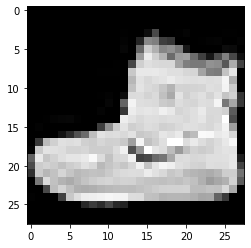

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline


image, label = trainingdata[0]
plt.figure()
plt.imshow(image[0]) 
plt.imshow(image.squeeze(), cmap="gray")


Let's try plotting several images. This is conveniently achieved in PyTorch using a *data loader*, which loads data in batches.

In [7]:
trainDataLoader = torch.utils.data.DataLoader(trainingdata, batch_size=64, shuffle=True)
testDataLoader = torch.utils.data.DataLoader(testdata, batch_size=64, shuffle=False)
images, labels = iter(trainDataLoader).next()
print(images.size(), labels)

torch.Size([64, 1, 28, 28]) tensor([7, 6, 2, 0, 3, 8, 1, 8, 6, 1, 9, 4, 7, 0, 6, 8, 0, 0, 1, 0, 6, 8, 0, 4,
        8, 8, 8, 0, 0, 0, 4, 6, 5, 9, 3, 4, 3, 2, 3, 9, 3, 5, 3, 8, 9, 3, 7, 1,
        8, 6, 6, 9, 3, 1, 8, 8, 9, 2, 8, 3, 5, 2, 6, 1])


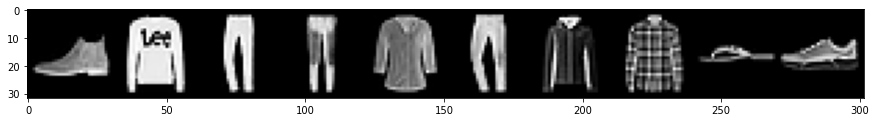

In [8]:
# Q4.4 Visualize the first 10 images of the first minibatch 
# returned by testDataLoader.
# ...
# ...
demo_loader = torch.utils.data.DataLoader(testdata, batch_size=10)

batch = next(iter(demo_loader))
images, labels = batch
grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))

Now we are ready to define our linear model. Here is some boilerplate PyTorch code that implements the forward model for a single layer network for logistic regression (similar to the one discussed in class notes). 

In [15]:
class LinearReg(torch.nn.Module):
  def __init__(self):
    super(LinearReg, self).__init__()
    self.linear = torch.nn.Linear(28*28,10)

  def forward(self, x):
    x = x.view(-1,28*28)
    transformed_x = self.linear(x)
    return transformed_x
    
net = LinearReg().cuda()
Loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)



Cool! Now we have set everything up. Let's try to train the network.

In [16]:
train_loss_history = []
test_loss_history = []

# Q4.5 Write down a for-loop that trains this network for 20 epochs,
# and print the train/test losses.
# Save them in the variables above. If done correctly, you should be able to # execute the next code block.

#trian the network for 20 epochs
epochs = 20

for epoch in range(int(epochs)):
# inital the current train_loss for each loop
    train_loss=0
    for i, batch in enumerate(trainDataLoader):
        images, labels = batch
        images, labels = images.cuda(), labels.cuda()
        # model forward pass
        output = net(images)
        #calculate the training loss
        loss = Loss(output, labels)
        optimizer.zero_grad()
        loss.backward()
        # update the parameters
        optimizer.step()
        train_loss += loss / images.size(0)
    #append the current train loss to the train_loss_history
    train_loss_history.append(train_loss/len(trainDataLoader))
    #set all the requires_grad flags to flase
    with torch.no_grad():
        test_loss = 0
        for i, batch in enumerate(testDataLoader):
            images, labels = batch
            images, labels = images.cuda(), labels.cuda() 
            output = net(images)
            loss = Loss(output, labels)
            test_loss += loss  / images.size(0)
        test_loss_history.append(test_loss/len(testDataLoader))

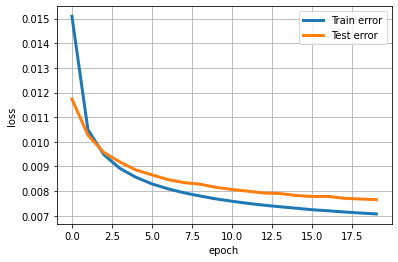

In [17]:
plt.plot(range(20),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(20),test_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

Neat! Now let's evaluate our model accuracy on the entire dataset. The predicted class label for a given input image can computed by looking at the output of the neural network model and computing the index corresponding to the maximum activation. Something like

*predicted_output = net(images)*
*_, predicted_labels = torch.max(predicted_output,1)*

In [22]:
predicted_output = net(images)
print(torch.max(predicted_output, 1))
fit = Loss(predicted_output, labels)
print(labels)

torch.return_types.max(
values=tensor([ 6.1396,  2.9139,  8.8612,  7.6527,  6.6246,  6.4528, 10.1330,  4.3723,
         6.9281, 11.6400, 10.5093, 10.4123,  6.6922,  4.7064,  9.4120,  4.5073],
       device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([3, 1, 7, 5, 8, 2, 5, 6, 8, 9, 1, 9, 1, 8, 1, 5], device='cuda:0'))
tensor([3, 2, 7, 5, 8, 4, 5, 6, 8, 9, 1, 9, 1, 8, 1, 5], device='cuda:0')


In [24]:
def evaluate(dataloader):
  # Q4.6 Implement a function here that evaluates training and testing accuracy.
  # Here, accuracy is measured by probability of successful classification.
  # ...
  # ...
  labelnum = 0 
  correctnum = 0
  with torch.no_grad():
    for i, each in enumerate(dataloader):
      images, labels = each
      images = images.cuda()
      labels = labels.cuda() 
      output = net(images)
      #get the predict result
      predict = torch.max(output, 1)[1]
      #calculate the number of correct prediction
      correctnum += torch.sum(predict==labels).item() 
      labelnum += len(labels)
  return correctnum / labelnum

print('Train acc = %0.2f, test acc = %0.2f' % (evaluate(trainDataLoader), evaluate(testDataLoader)))

Train acc = 0.85, test acc = 0.83
